In [138]:
# downloading dataset from kaggle

! pip3 install keras

! pip install kaggle --upgrade
 
! KAGGLE_USERNAME="ephobia" KAGGLE_KEY="5b1e884343d9f9b18bb2dd73299f3086" kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip --force

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.0)
100% 7.36G/7.37G [01:23<00:00, 122MB/s]
100% 7.37G/7.37G [01:23<00:00, 94.3MB/s]


In [5]:
! unzip train_simplified.zip -d train_data
! ls

Archive:  train_simplified.zip
  inflating: train_data/fence.csv    
  inflating: train_data/yoga.csv     
  inflating: train_data/horse.csv    
  inflating: train_data/sandwich.csv  
  inflating: train_data/cat.csv      
  inflating: train_data/camouflage.csv  
  inflating: train_data/mosquito.csv  
  inflating: train_data/see saw.csv  
  inflating: train_data/onion.csv    
  inflating: train_data/grapes.csv   
  inflating: train_data/chandelier.csv  
  inflating: train_data/stitches.csv  
  inflating: train_data/sink.csv     
  inflating: train_data/trumpet.csv  
  inflating: train_data/cell phone.csv  
  inflating: train_data/skyscraper.csv  
  inflating: train_data/hourglass.csv  
  inflating: train_data/donut.csv    
  inflating: train_data/ceiling fan.csv  
  inflating: train_data/bowtie.csv   
  inflating: train_data/lipstick.csv  
  inflating: train_data/suitcase.csv  
  inflating: train_data/moon.csv     
  inflating: train_data/dishwasher.csv  
  inflating: train_data/mermaid

In [0]:
import numpy as np
import zipfile
import pandas as pd
import tqdm
import matplotlib 
import matplotlib.pyplot as plt
import csv
import os


zf = zipfile.ZipFile("train_simplified.zip")

class_labels = [x.replace(".csv", "") for x in zf.namelist()]


# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
  while True:
    with open(os.path.join('train_data', fn), "r") as f:
      f.readline()  # skip header
      lines = csv.reader(f, delimiter=',', quotechar='"')
      for line in lines:
        yield line[1], line[5]
      if debug:
        print(fn, "is done, starting from the beginning...")


In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        np.random.seed(42)
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [next(gen) for gen in generators[random_indices]]


In [0]:
import ast
from PIL import Image, ImageDraw

IMG_SIZE = 224

# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256, 256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i + 1], 
                             stroke[1][i + 1]],
                            fill=0, width=5)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    return np.array(image, dtype=np.uint8)

  
def vector_output(csvs):
  outputs = {}
  for i, name in enumerate(csvs):
    vec = np.zeros(340)
    vec[i] = 1
    outputs[name[:-4]] = vec
  return outputs

  
def images_and_labels_generator(batch_size):
  #outputs = vector_output(os.listdir("train_data"))
  for batch in raw_batch_generator(batch_size):
    batch_images = []
    batch_labels = []
    for e in batch:
      batch_images.append(draw_it(e[0]))
      batch_labels.append(e[1])
    batch_images = np.stack(batch_images, axis=0)
    yield batch_images, batch_labels  

In [0]:
import tensorflow as tf
import keras
from keras import backend as K


# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}

def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization


def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential() 
    
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    model.add(Flatten()) 
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [12]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 16)      0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`


In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

METRICS = []

def top_3_accuracy(y_true, y_pred):
  value = top_k_categorical_accuracy(y_true, y_pred, k=3)
  METRICS.append(value)
  return value

In [14]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`


In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
last_finished_epoch = 0

In [17]:
# fit the model with our eternal generator!
hist = model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 54s 358ms/step - loss: 2.9935 - categorical_accuracy: 0.2858 - top_3_accuracy: 0.4744
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 49s 327ms/step - loss: 1.9360 - categorical_accuracy: 0.4762 - top_3_accuracy: 0.7021
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 49s 327ms/step - loss: 1.7024 - categorical_accuracy: 0.5340 - top_3_accuracy: 0.7504
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 49s 327ms/step - loss: 1.5382 - categorical_accuracy: 0.5777 - top_3_accuracy: 0.7863
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 49s 326ms/step - loss: 1.4443 - categorical_accuracy: 0.6085 - top_3_accuracy: 0.8025
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 49s 327ms/step - loss: 1.4160 - categorical_accuracy: 0.6102 - top_3_accuracy: 0.8065
Model saved in model_5
Epoch 7/10
150/150 [==

# Эксперименты с моделью

In [18]:
def make_model2():

    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(GlobalAveragePooling2D())  
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()
model2 = make_model2()
model2.summary()

model2.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 16)      0         
__________

In [19]:
hist2 = model2.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 49s 327ms/step - loss: 4.0245 - categorical_accuracy: 0.0627 - top_3_accuracy: 0.1498
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 48s 322ms/step - loss: 3.0340 - categorical_accuracy: 0.1446 - top_3_accuracy: 0.3552
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 49s 324ms/step - loss: 2.6456 - categorical_accuracy: 0.2454 - top_3_accuracy: 0.4898
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 50s 333ms/step - loss: 2.4954 - categorical_accuracy: 0.2840 - top_3_accuracy: 0.5217
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 50s 336ms/step - loss: 2.4595 - categorical_accuracy: 0.2892 - top_3_accuracy: 0.5387
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 55s 368ms/step - loss: 2.4025 - categorical_accuracy: 0.2994 - top_3_accuracy: 0.5556
Model saved in model_5
Epoch 7/10
150/150 [==

In [20]:
def make_model3():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    model.add(Flatten()) 
    model.add(Dropout(0.30))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()
model3 = make_model3()
model3.summary()

model3.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 16)      0         
__________

In [21]:
hist3 = model3.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 80s 535ms/step - loss: 3.0254 - categorical_accuracy: 0.2929 - top_3_accuracy: 0.4908
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 78s 522ms/step - loss: 1.8657 - categorical_accuracy: 0.4960 - top_3_accuracy: 0.7215
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 49s 328ms/step - loss: 1.5953 - categorical_accuracy: 0.5581 - top_3_accuracy: 0.7704
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 49s 329ms/step - loss: 1.4532 - categorical_accuracy: 0.6021 - top_3_accuracy: 0.7965
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 49s 328ms/step - loss: 1.3811 - categorical_accuracy: 0.6238 - top_3_accuracy: 0.8173
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 50s 330ms/step - loss: 1.3341 - categorical_accuracy: 0.6333 - top_3_accuracy: 0.8231
Model saved in model_5
Epoch 7/10
150/150 [==

In [22]:
def make_model4():

    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(64, (3, 3), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    model.add(Flatten()) 
    model.add(Dropout(0.30))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()
model4 = make_model4()
model4.summary()

model4.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 64)      0         
__________

In [40]:
hist4 = model4.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 70s 470ms/step - loss: 2.4480 - categorical_accuracy: 0.2571 - top_3_accuracy: 0.5248
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 70s 468ms/step - loss: 2.4374 - categorical_accuracy: 0.2579 - top_3_accuracy: 0.5337
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 70s 468ms/step - loss: 2.3929 - categorical_accuracy: 0.2708 - top_3_accuracy: 0.5440
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 70s 469ms/step - loss: 2.3718 - categorical_accuracy: 0.2765 - top_3_accuracy: 0.5521
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 70s 469ms/step - loss: 2.3536 - categorical_accuracy: 0.2900 - top_3_accuracy: 0.5583
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 70s 469ms/step - loss: 2.3372 - categorical_accuracy: 0.2931 - top_3_accuracy: 0.5779
Model saved in model_5
Epoch 7/10
150/150 [==

In [129]:
def make_model5():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Flatten()) 
    model.add(Dropout(0.30))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()
model5 = make_model5()
model5.summary()

model5.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 16)      0         
__________

In [133]:
hist5 = model5.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback("model_{}")],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 51s 338ms/step - loss: 1.3367 - categorical_accuracy: 0.6231 - top_3_accuracy: 0.8142
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 51s 338ms/step - loss: 1.3829 - categorical_accuracy: 0.6269 - top_3_accuracy: 0.8100
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 51s 338ms/step - loss: 1.2502 - categorical_accuracy: 0.6573 - top_3_accuracy: 0.8333
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 51s 337ms/step - loss: 1.1765 - categorical_accuracy: 0.6756 - top_3_accuracy: 0.8490
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 51s 338ms/step - loss: 1.0847 - categorical_accuracy: 0.6967 - top_3_accuracy: 0.8598
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 51s 338ms/step - loss: 1.0523 - categorical_accuracy: 0.7071 - top_3_accuracy: 0.8688
Model saved in model_5
Epoch 7/10
150/150 [==

**ВЫВОДЫ ОБ АРХИТЕКТУРЕ:**


---

1) Наличие дополнительного сверточного слоя не влияет на качество существенно

2) Наличие Flatten сильно улучшает качество метрик

3) Dropout 25% нейронов не влияет на качество метрик, а 30% немного их повышает

4) Если увеличить размер фильтра, то очень сильно понижается скорость и качество обучения

5) Добавление сверточных слоев очень сильно уменьшает количество параметров и улучшает качество

Text(0,0.5,'Loss')

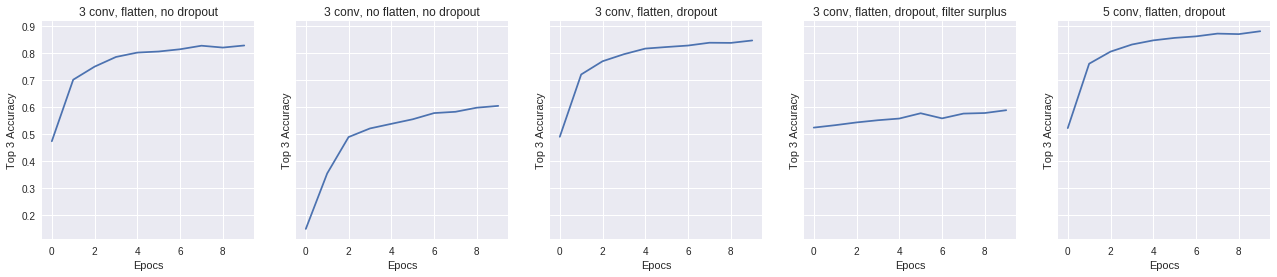

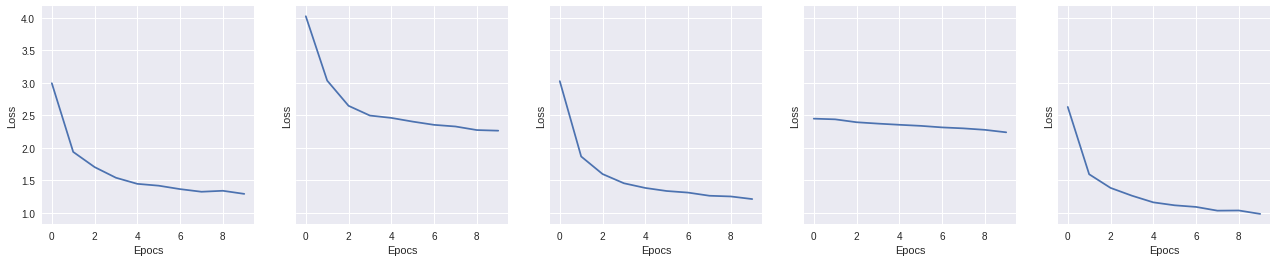

In [49]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    nrows=1, ncols=5,
    figsize=(22, 4),
    sharey = True
)

ax1.set_title('3 conv, flatten, no dropout')
ax1.plot(hist.history['top_3_accuracy'])
ax1.set_xlabel('Epocs')
ax1.set_ylabel('Top 3 Accuracy')

ax2.set_title('3 conv, no flatten, no dropout')
ax2.plot(hist2.history['top_3_accuracy'])
ax2.set_xlabel('Epocs')
ax2.set_ylabel('Top 3 Accuracy')

ax3.set_title('3 conv, flatten, dropout')
ax3.plot(hist3.history['top_3_accuracy'])
ax3.set_xlabel('Epocs')
ax3.set_ylabel('Top 3 Accuracy')

ax4.set_title('3 conv, flatten, dropout, filter surplus')
ax4.plot(hist4.history['top_3_accuracy'])
ax4.set_xlabel('Epocs')
ax4.set_ylabel('Top 3 Accuracy')

ax5.set_title('5 conv, flatten, dropout')
ax5.plot(hist5.history['top_3_accuracy'])
ax5.set_xlabel('Epocs')
ax5.set_ylabel('Top 3 Accuracy')


fig2, (ax6, ax7, ax8, ax9, ax10) = plt.subplots(
    nrows=1, ncols=5,
    figsize=(22, 4),
    sharey = True
)


ax6.plot(hist.history['loss'])
ax6.set_xlabel('Epocs')
ax6.set_ylabel('Loss')

ax7.plot(hist2.history['loss'])
ax7.set_xlabel('Epocs')
ax7.set_ylabel('Loss')

ax8.plot(hist3.history['loss'])
ax8.set_xlabel('Epocs')
ax8.set_ylabel('Loss')

ax9.plot(hist4.history['loss'])
ax9.set_xlabel('Epocs')
ax9.set_ylabel('Loss')

ax10.plot(hist5.history['loss'])
ax10.set_xlabel('Epocs')
ax10.set_ylabel('Loss')

# **Эксперименты с Аугментацией**

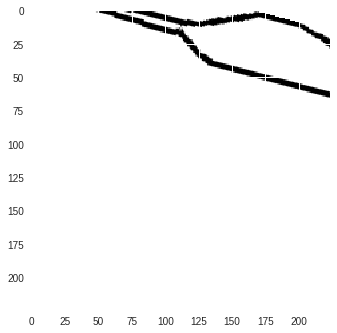

In [107]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    cval=255
)

def augmentated_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            img = draw_it(e[0])
            img = np.tile(np.expand_dims(img, axis=2), (1, 1, 3))
            img = image_gen.random_transform(img)
            batch_images.append(img)
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels


b = next(augmentated_generator(32))

plt.imshow(b[0][10, :, :])

In [0]:
def aug_train_iterator(batch_size):
    for batch in augmentated_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield images, labels

In [109]:
def make_model6():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))) 
    model.add(Conv2D(64, (3, 3), activation='relu')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Conv2D(16, (5, 5), activation='relu', border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(MaxPooling2D()) 
    
    model.add(Flatten()) 
    model.add(Dropout(0.30))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

BATCH_SIZE = 32
STEPS_PER_EPOCH = 150
EPOCHS = 10

s = reset_tf_session()
model6 = make_model6()
model6.summary()

model6.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),
    metrics=[categorical_accuracy, top_3_accuracy]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 16)      25616     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 16)      0         
__________

In [110]:
hist6 = model6.fit_generator(
    aug_train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/10
150/150 [==============================] - 75s 497ms/step - loss: 2.0292 - categorical_accuracy: 0.5019 - top_3_accuracy: 0.6608
Model saved in model_0
Epoch 2/10
150/150 [==============================] - 73s 484ms/step - loss: 0.8373 - categorical_accuracy: 0.7612 - top_3_accuracy: 0.8960
Model saved in model_1
Epoch 3/10
150/150 [==============================] - 73s 489ms/step - loss: 0.5518 - categorical_accuracy: 0.8377 - top_3_accuracy: 0.9460
Model saved in model_2
Epoch 4/10
150/150 [==============================] - 73s 489ms/step - loss: 0.4302 - categorical_accuracy: 0.8792 - top_3_accuracy: 0.9656
Model saved in model_3
Epoch 5/10
150/150 [==============================] - 73s 489ms/step - loss: 0.3413 - categorical_accuracy: 0.8975 - top_3_accuracy: 0.9729
Model saved in model_4
Epoch 6/10
150/150 [==============================] - 74s 491ms/step - loss: 0.2733 - categorical_accuracy: 0.9146 - top_3_accuracy: 0.9850
Model saved in model_5
Epoch 7/10
150/150 [==

Text(0,0.5,'Top 3 Accuracy')

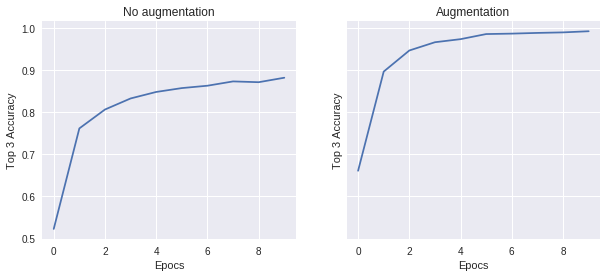

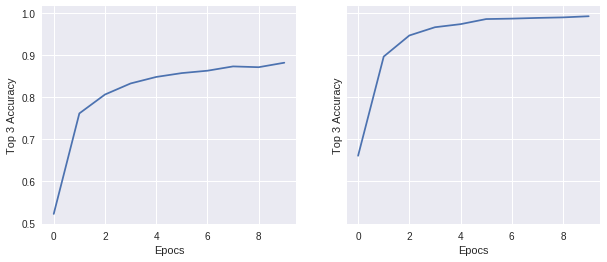

In [112]:
fig3, (ax11, ax12) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 4),
    sharey = True
)

ax11.set_title('No augmentation')
ax11.plot(hist5.history['top_3_accuracy'])
ax11.set_xlabel('Epocs')
ax11.set_ylabel('Top 3 Accuracy')

ax12.set_title('Augmentation')
ax12.plot(hist6.history['top_3_accuracy'])
ax12.set_xlabel('Epocs')
ax12.set_ylabel('Top 3 Accuracy')


fig4, (ax21, ax22) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 4),
    sharey = True
)

ax21.plot(hist5.history['top_3_accuracy'])
ax21.set_xlabel('Epocs')
ax21.set_ylabel('Top 3 Accuracy')

ax22.plot(hist6.history['top_3_accuracy'])
ax22.set_xlabel('Epocs')
ax22.set_ylabel('Top 3 Accuracy')

# Тестируем

In [113]:
# download test set
! KAGGLE_USERNAME="ephobia" KAGGLE_KEY="5b1e884343d9f9b18bb2dd73299f3086" kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

 83% 49.0M/59.0M [00:00<00:00, 35.1MB/s]
100% 59.0M/59.0M [00:00<00:00, 73.2MB/s]


In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images / 255 - 0.5
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images / 255 - 0.5
            yield batch_keys, batch_images

In [115]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [134]:
# you can continue from snapshot!!!
from keras.models import load_model
s = reset_tf_session()
last_finished_epoch = 9
test_model = load_model("model_{}".format(last_finished_epoch), 
                    custom_objects={"top_3_accuracy": top_3_accuracy})
global graph
graph = tf.get_default_graph()

with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        with graph.as_default():
          probas = test_model.predict_proba(batch_images, BATCH_SIZE)
          top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
          labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
          for key, labels in zip(batch_keys, labels):
              f.write(key + "," + labels + "\n")

  3%|▎         | 101/3507.0 [00:16<09:21,  6.06it/s]Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f6904933278>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68fa324828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/

In [135]:
! wc -l submission.csv

112200 submission.csv


In [136]:
# submit to kaggle
! KAGGLE_USERNAME="ephobia" KAGGLE_KEY="5b1e884343d9f9b18bb2dd73299f3086" kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "My precious"

100% 4.31M/4.31M [00:04<00:00, 915kB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge